Image data type: float32
Image max value after normalization: 0.43255501985549927
Image min value after normalization: 0.10067622363567352
High-resolution image shape: (1054, 1054, 4)
High-resolution image min value: 0.0
High-resolution image max value: 1.0
Low-resolution image shape: (1054, 1054, 4)
Low-resolution image min value: 0.10067622363567352
Low-resolution image max value: 0.5563187599182129


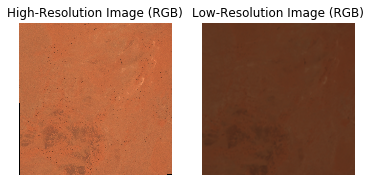

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import cv2
import os

# Updated preprocess_tiff function with additional checks
def preprocess_tiff(image_path, target_size):
    with rasterio.open(image_path) as src:
        red_band = src.read(4).astype(np.float32)  # Band 4
        green_band = src.read(3).astype(np.float32)  # Band 3
        blue_band = src.read(2).astype(np.float32)  # Band 2
        rgb_image = np.dstack((red_band, green_band, blue_band))
        rgb_image = cv2.resize(rgb_image, target_size, interpolation=cv2.INTER_CUBIC)
        
        # Normalize to 0 to 1
        rgb_image = np.clip(rgb_image, 0, 255)
        if np.max(rgb_image) > 1:
            rgb_image /= 255.0  
        
        # Additional check for data type and range
        print(f"Image data type: {rgb_image.dtype}")
        print(f"Image max value after normalization: {np.max(rgb_image)}")
        print(f"Image min value after normalization: {np.min(rgb_image)}")

    return rgb_image

# Updated preprocess_image function to handle land cover images
def preprocess_image(hr_file, lr_dir, hr_dir, lc_dir, target_size):
    hr_image_path = os.path.join(hr_dir, hr_file)
    base_name = hr_file.replace('_rgb.png', '')
    
    # Load high-resolution image (RGB)
    hr_image = load_image(hr_image_path)
    
    # Load low-resolution image (RGB)
    lr_image_file = f"{base_name}-L2A_data.tiff"
    lr_image_path = os.path.join(lr_dir, lr_image_file)
    lr_image = preprocess_tiff(lr_image_path, target_size)
    
    # Load landcover band (without normalization)
    lc_image_file = f"{base_name}.tif"
    lc_image_path = os.path.join(lc_dir, lc_image_file)
    with rasterio.open(lc_image_path) as src:
        lc_band = src.read(1).astype(np.float32)
        lc_band = cv2.resize(lc_band, target_size, interpolation=cv2.INTER_CUBIC)
        lc_band = np.expand_dims(lc_band, axis=-1)
    
    # Ensure low-resolution image is in the correct range
    lr_image = np.clip(lr_image, 0, 1)
    
    # Concatenate the landcover band to the RGB images
    hr_image = np.concatenate((hr_image, lc_band), axis=-1)
    lr_image = np.concatenate((lr_image, lc_band), axis=-1)
    
    return hr_image, lr_image

# Function to load and preprocess standard images
def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file {image_path} does not exist.")
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Failed to load image {image_path}.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize to 0 to 1
    return image

# Test function
def test_preprocess_image():
    # Paths to directories
    hr_dir = 'high_resolution_final'
    lr_dir = 'low_resolution_final'
    lc_dir = 'land_cover_final'
    
    # Sample high-resolution image file
    hr_file = 'Landcover-1000781_rgb.png'
    
    # Desired target size for the image
    target_size = (1054, 1054)
    
    # Call the preprocess_image function
    hr_image, lr_image = preprocess_image(hr_file, lr_dir, hr_dir, lc_dir, target_size)
    
    # Print image properties
    print(f"High-resolution image shape: {hr_image.shape}")
    print(f"High-resolution image min value: {hr_image.min()}")
    print(f"High-resolution image max value: {hr_image.max()}")
    
    print(f"Low-resolution image shape: {lr_image.shape}")
    print(f"Low-resolution image min value: {lr_image.min()}")
    print(f"Low-resolution image max value: {lr_image.max()}")
    
    # Display the processed images
    plt.subplot(1, 2, 1)
    plt.imshow(hr_image[:, :, :3])
    plt.title('High-Resolution Image (RGB)')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(lr_image[:, :, :3])
    plt.title('Low-Resolution Image (RGB)')
    plt.axis('off')
    
    plt.show()

# Run the test
test_preprocess_image()
